In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#"Background only" i.e. no anomalies in this dataset
myfile = open("/data0/users/bpnachman/anomaly/processed_lhe001_background.txt")

#Want to make new particles with a given mass.  E = mc^2
#Instead electron + electron -> new particle -> stuff we sift through
#electron + electron -> photon + new particle -> stuff

all_records = []
mymeasuredenergy = []
count = 0
for line in myfile:
    
    metadata = line.split("J")[0]
    eventinfo = line.split("J")[1]
    jets = eventinfo.split("P")[0]
    particles = eventinfo.split("P")[1]
    
    this_record = {}
    this_record['label'] = count
    count += 1
    eventweight = float(metadata.split()[0])
    this_record['eventweight'] = eventweight #this is the event "weight".  Let's ignoreit for now (we will need it later).
    njets = int(len(jets.split())/11) #number of "jets"
    
    nparticles  = int(len(particles.split())/5) #number of particles
    
    
    
    
    #True collision quantities
    this_record['truthcenterofmassenergy'] = float(metadata.split()[1]) #true total energy - should be delta function at 1000 GeV
    this_record['truthsqrtshat'] = float(metadata.split()[2]) #energy available for making new particles (electron energy - photon)
    this_record['truthphotonpT'] = float(metadata.split()[3]) #photon momentum |p| in units of GeV
    this_record['truthphotoneta'] = float(metadata.split()[4]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
    this_record['truthphotonphi'] = float(metadata.split()[5]) #photon azimuthal angle

    #Measured collision quantities
    measuredcenterofmassenergy  = float(metadata.split()[6]) #true measured energy - should be noisy version of truthcenterofmassenergy
    this_record['measuredcenterofmassenergy'] = measuredcenterofmassenergy
    this_record['measuredsqrtshat'] = float(metadata.split()[7]) #energy available for making new particles (electron energy - photon)
    this_record['measuredphotonpT'] = float(metadata.split()[8]) #photon momentum |p| in units of GeV
    this_record['measuredphotoneta'] = float(metadata.split()[9]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
    this_record['measuredphotonphi'] = float(metadata.split()[10]) #photon azimuthal angle
    this_record['metadata'] = metadata.split()

    mymeasuredenergy+=[measuredcenterofmassenergy]

    this_record['njets'] = njets
    jets = jets.split()
    jets_vec = []
    for i in range(njets):
        jet = np.zeros(11)
        #order:
        # - index
        # - magnitude of momentum |p| (units of GeV)
        # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        # - azimuthal angle
        # - mass (units of GeV/c^2)
        # - bit encoding of the jet "flavor" (not totally sure what the bit means, but will look it up)
        # - 0th angular moment of jet radiation
        # - 1th angular moment of jet radiation
        # - 2th angular moment of jet radiation
        # - 3th angular moment of jet radiation
        # - 4th angular moment of jet radiation
        jet = jets[i*11:i*11+11]
        jets_vec+=[jet]
        
    this_record['jets']=jets_vec
    
    this_record['nparticles'] = nparticles
    
    particles = particles.split()
    particles_vec = []
    for i in range(nparticles):
        particle = np.zeros(5)
        #order:
        # - index
        # - magnitude of momentum |p| (units of GeV)
        # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        # - azimuthal angle
        # - particle identifier (https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf)
        particle = particles[i*5:i*5+5]
        particles_vec+=[particle]
        #print(particles[i*5],particles[i*5+1],particles[i*5+2],particles[i*5+3],particles[i*5+4])
    this_record['particles'] = particles_vec

    all_records.append(this_record)

In [3]:
all_records[2]

{'label': 2,
 'eventweight': 0.342393,
 'truthcenterofmassenergy': 1000.0,
 'truthsqrtshat': 962.971,
 'truthphotonpT': 5.46983,
 'truthphotoneta': 2.5812,
 'truthphotonphi': -3.06883,
 'measuredcenterofmassenergy': 907.012,
 'measuredsqrtshat': 182.412,
 'measuredphotonpT': 124.548,
 'measuredphotoneta': -2.04711,
 'measuredphotonphi': 0.448909,
 'metadata': ['0.342393',
  '1000',
  '962.971',
  '5.46983',
  '2.5812',
  '-3.06883',
  '907.012',
  '182.412',
  '124.548',
  '-2.04711',
  '0.448909'],
 'njets': 3,
 'jets': [['0',
   '49.7791',
   '2.40904',
   '-3.08059',
   '8.52077',
   '3',
   '0.119631',
   '0.0862247',
   '0.0603597',
   '0.044477',
   '0.0372949'],
  ['1',
   '39.2359',
   '1.656',
   '-2.18411',
   '10.3381',
   '0',
   '0.212412',
   '0.151033',
   '0.123118',
   '0.101883',
   '0.0770021'],
  ['2',
   '26.9277',
   '-0.410937',
   '-2.5438',
   '14.7735',
   '99',
   '0.433979',
   '0.219466',
   '0.168326',
   '0.14532',
   '0.116208']],
 'nparticles': 64,
 'pa

Text(0, 0.5, 'Number of Events / bin')

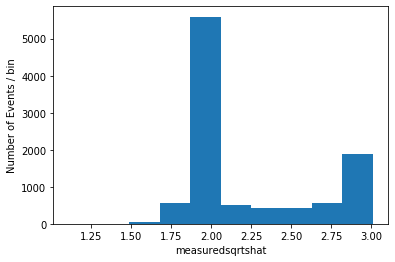

In [43]:
this_arr = np.array([i['measuredsqrtshat'] for i in all_records])
plt.hist(np.log10(this_arr))
plt.xlabel("measuredsqrtshat")
plt.ylabel("Number of Events / bin")

## EFN experimenting

### imports and settings

In [33]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical
from sklearn.metrics import roc_auc_score, roc_curve


In [34]:
train, val, test = 7500, 1000, 1500
use_pids = True
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
num_epoch = 5
batch_size = 100

### Save particles only as X

Save all particles in 3d array. dim 0 = datapoints; dim 1 = particles; dim 2 = particle features.

Particle features have original index 0 omitted. new index 0, 1, 2 are numerical. index 3 is PID

In [69]:
max_nparticles = max([i['nparticles'] for i in all_records])

In [70]:
padded_part_arrays =[]
for record in all_records:
    # convert to np array
    these_particles = np.array(record['particles']).astype('float')
    # omit index 0
    these_particles = these_particles[:,1:]
    # determine how many zero values to pad
    pad_length = max_nparticles - these_particles.shape[0]
    #pad
    padded_particles = np.pad(these_particles, ((0,pad_length),(0,0)))
    # check padding
    assert padded_particles.shape == (max_nparticles, 4)
    # add to list
    padded_part_arrays.append(padded_particles)
    
all_particle_array = np.array(padded_part_arrays)
X = all_particle_array

In [71]:
X.shape

(10000, 344, 4)

### Save measured centerofmassEnergy as y

In [62]:
y = np.array([i['measuredcenterofmassenergy'] for i in all_records])

In [63]:
# reshape using log for better distribution
y_log = np.log10(y)

In [64]:
max_ylog= max(y_log)

In [65]:
Yleft = y_log/max_ylog
Yright = 1 - Yleft
Y = np.vstack([Yleft, Yright]).T
Y.shape

(10000, 2)

### Preprocessing

In [72]:
# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

In [76]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

### Building the model

In [77]:
# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              
__________________________________________________________________________________________________
activation

### Training

In [79]:
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

Train on 7500 samples, validate on 1000 samples
Epoch 1/5
7500/7500 [==============================] - 1s 81us/step - loss: 7.8355 - acc: 0.5139 - val_loss: 8.4136 - val_acc: 0.4780
Epoch 2/5
7500/7500 [==============================] - 1s 77us/step - loss: 7.8355 - acc: 0.5139 - val_loss: 8.4136 - val_acc: 0.4780
Epoch 3/5
7500/7500 [==============================] - 1s 77us/step - loss: 7.8355 - acc: 0.5139 - val_loss: 8.4136 - val_acc: 0.4780
Epoch 4/5
7500/7500 [==============================] - 1s 79us/step - loss: 7.8355 - acc: 0.5139 - val_loss: 8.4136 - val_acc: 0.4780
Epoch 5/5
7500/7500 [==============================] - 1s 78us/step - loss: 7.8355 - acc: 0.5139 - val_loss: 8.4136 - val_acc: 0.4780


In [ ]:
#Later for ML: https://energyflow.network/examples/